<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [464]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [465]:
data = pd.read_csv('taxi.csv')

In [466]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


В данных имеется 2 поля - временной ряд и количество заказов, поле datetime имеет шаг 10 минут

In [467]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропущенные значения отсутствуют

In [468]:
data.duplicated().sum()

0

Полные дубликаты отсутствуют

Установим индексом поле datetime

In [469]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Сделаем ресемплирование по одному часу

In [470]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [471]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод

На данном этапе можно отметить следующее:
* данные содержат заказы с марта по август 2018 года
* полные дубликаты и пропущенные значения отсутствуют
* было проведено ресемплирование с 10 минут до одного часа

## Анализ

Построим гистограмму частот

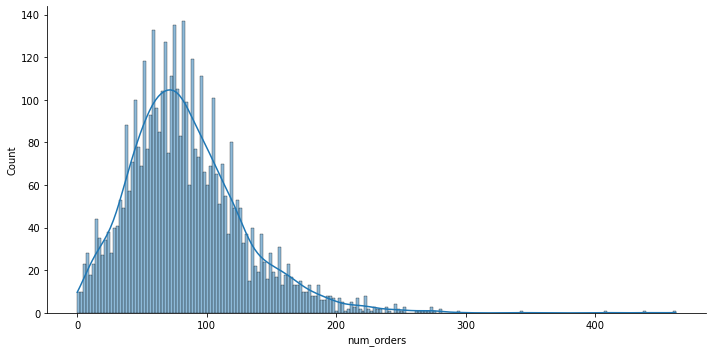

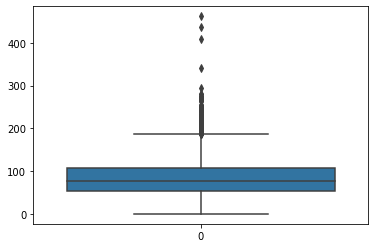

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [472]:
sns.displot(data['num_orders'],bins=200, kde=True, height=5, aspect=2)
plt.show()
sns.boxplot(data=data['num_orders'])
plt.show()
#plt.ylim(-10, 400)
data.describe()

Из графика видно, что в среднем происходит 84 заказа в час, как правило количество заказов не поднимается выше 250.

Построим графики по данным, посмотрим тренд и сезонность 

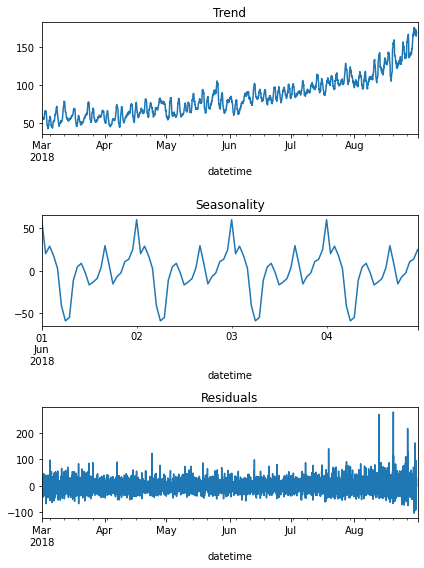

In [473]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-04'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

### Вывод

В среднем в час происходит 84 заказа. Имеется тренд увеличение количества заказов в течение года. Сенонность указывает на резкое увеличение заказов ближе к полуночи, это может быть связано с понижение частоты хождения общественного транспорта и закрытия метро. Спад логично приходится на 6 утра и опять резко возрастает к 8, когда многие едут на работу.

## Обучение

Напишем функцию для создания признаков

In [474]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
# применим функцию для создания признаков
make_features(data, 24, 10)
data = data.dropna()

Разделим данные на выборки

In [475]:
features = data.drop(['num_orders'],axis=1)
target = data['num_orders']

features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, shuffle=False, train_size=0.8, test_size=0.2, random_state=12345)

features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid, target_valid, shuffle=False, train_size=0.5,\
    test_size=0.5, random_state=12345)

print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (3513, 28)
Размер валидационной выборки: (439, 28)
Размер тестовой выборки: (440, 28)


Обучим разные модели с разными гиперпараметрами

#### LinearRegression

In [476]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

start = time.time() 
predictions = model_lr.predict(features_valid)
predict_time = time.time() - start


mse = mean_squared_error(target_valid, predictions)
RMSE = sqrt(mse)

results1 = []
results1.append({'Модель' : 'LinearRegression',
                'Скорость предсказания': predict_time, 
                'RMSE': RMSE})

LinearRegression_results = pd.DataFrame.from_dict(results1).sort_values(by='RMSE').reset_index(drop=True).head()
LinearRegression_results

,Модель,Скорость предсказания,RMSE
0,LinearRegression,0.004758,34.310076


#### RandomForestRegressor

In [477]:
%%time
results2 = []
best_model_rf = None
best_result_rf = 100

for est in range(10, 101, 10):
    for depth in range (1, 21):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        start = time.time() 
        predictions = model_rf.predict(features_valid)
        predict_time = time.time() - start

    
        mse = mean_squared_error(target_valid, predictions)
        RMSE = sqrt(mse)

                
        if RMSE < best_result_rf:
            best_result_rf = RMSE
            best_model_rf = model_rf

        
        results2.append({'Модель' : 'RandomForestRegressor',
                        'Hyperparameters': {'n_estimators': est, 
                                              'max_depth': depth},
                        'Скорость предсказания': predict_time, 
                        'RMSE': RMSE})


CPU times: user 5min 9s, sys: 1.47 s, total: 5min 10s
Wall time: 5min 12s


In [478]:
RandomForestRegressor_results = pd.DataFrame.from_dict(results2).sort_values(by='RMSE').reset_index(drop=True).head()
RandomForestRegressor_results

,Модель,Hyperparameters,Скорость предсказания,RMSE
0,RandomForestRegressor,"{'n_estimators': 100, 'max_depth': 14}",0.013970,32.515082
1,RandomForestRegressor,"{'n_estimators': 90, 'max_depth': 14}",0.012979,32.534852
2,RandomForestRegressor,"{'n_estimators': 80, 'max_depth': 14}",0.012400,32.542673
3,RandomForestRegressor,"{'n_estimators': 100, 'max_depth': 20}",0.015863,32.543176
4,RandomForestRegressor,"{'n_estimators': 100, 'max_depth': 19}",0.015795,32.554096


#### LGBMRegressor

In [479]:
%%time
results3 = []
best_model_lgbm = None
best_result_lgbm = 100

for boosting_type in ['gbdt', 'dart', 'goss']:
    for n_estimators in range(10, 101, 20):
        model_lgbm = LGBMRegressor(boosting_type=boosting_type,
                                  n_estimators=n_estimators,
                                  random_seed = 12345)
        model_lgbm.fit(features_train, target_train) 
        start = time.time() 
        predictions_lgbm = model_lgbm.predict(features_valid, verbose=2)
        predict_time = time.time() - start
        
        mse = mean_squared_error(target_valid, predictions_lgbm)
        RMSE = sqrt(mse)
        
        if RMSE < best_result_lgbm:
            best_result_lgbm = RMSE
            best_model_lgbm = model_lgbm

        
        results3.append({'Модель' : 'LGBMRegressor',
                        'Тип бустинга': boosting_type,
                        'n_estimators': n_estimators, 
                        'Скорость предсказания': predict_time, 
                        'RMSE': RMSE})

CPU times: user 5.9 s, sys: 414 ms, total: 6.32 s
Wall time: 2.02 s


In [480]:
LGBM_results = pd.DataFrame.from_dict(results3).sort_values(by='RMSE').reset_index(drop=True).head()
LGBM_results

,Модель,Тип бустинга,n_estimators,Скорость предсказания,RMSE
0,LGBMRegressor,goss,90,0.003856,32.777508
1,LGBMRegressor,goss,70,0.003981,32.790042
2,LGBMRegressor,gbdt,90,0.003979,32.876500
3,LGBMRegressor,gbdt,70,0.003808,32.939317
4,LGBMRegressor,goss,50,0.003552,33.162610


#### CatBoostRegressor

In [481]:
%%time
results = []
best_model_cbr = None
best_result_cbr = 100
for iteration in range(10, 101, 20):
    for depth in range(5, 11, 2):
        model_cbr = CatBoostRegressor(loss_function = "RMSE",
                                      iterations = iteration,
                                      depth = depth,
                                      random_seed = 12345)
        model_cbr.fit(features_train, target_train)



        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid, verbose=2)
        predict_time = time.time() - start
        mse = mean_squared_error(target_valid, predictions_cbr)
        RMSE = sqrt(mse)
        
        if RMSE < best_result_cbr:
            best_result_cbr = RMSE
            best_model_cbr = model_cbr

        results.append({'Модель' : 'CatBoostRegressor',
                        'Итерации': iteration,
                        'Глубина': depth, 
                        'Скорость предсказания': predict_time, 
                        'RMSE': RMSE})
        


Learning rate set to 0.5
0:	learn: 29.9169804	total: 5.59ms	remaining: 50.3ms
1:	learn: 26.7629950	total: 9.27ms	remaining: 37.1ms
2:	learn: 24.7408538	total: 11.9ms	remaining: 27.8ms
3:	learn: 23.8939640	total: 14.6ms	remaining: 21.9ms
4:	learn: 23.3979411	total: 17.2ms	remaining: 17.2ms
5:	learn: 23.1208173	total: 19.9ms	remaining: 13.3ms
6:	learn: 22.7399668	total: 22.9ms	remaining: 9.81ms
7:	learn: 22.4632489	total: 26.9ms	remaining: 6.74ms
8:	learn: 22.3418514	total: 30.3ms	remaining: 3.36ms
9:	learn: 22.2232699	total: 35ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 29.2443926	total: 8.72ms	remaining: 78.5ms
1:	learn: 25.8600159	total: 14.3ms	remaining: 57.3ms
2:	learn: 23.9652664	total: 20.3ms	remaining: 47.3ms
3:	learn: 22.8972326	total: 26ms	remaining: 39.1ms
4:	learn: 22.1697671	total: 31.7ms	remaining: 31.7ms
5:	learn: 21.6064622	total: 38.1ms	remaining: 25.4ms
6:	learn: 21.3560128	total: 47.6ms	remaining: 20.4ms
7:	learn: 21.0082611	total: 58ms	remaining: 14.5ms
8:	le

2:	learn: 24.2154887	total: 21.5ms	remaining: 337ms
3:	learn: 23.1928403	total: 38.4ms	remaining: 442ms
4:	learn: 22.4107192	total: 51.7ms	remaining: 465ms
5:	learn: 21.9166548	total: 58.7ms	remaining: 430ms
6:	learn: 21.7108981	total: 65.9ms	remaining: 405ms
7:	learn: 21.4604049	total: 72.1ms	remaining: 379ms
8:	learn: 21.1853985	total: 81.3ms	remaining: 370ms
9:	learn: 20.8078073	total: 92.6ms	remaining: 370ms
10:	learn: 20.5408726	total: 105ms	remaining: 373ms
11:	learn: 20.4001048	total: 111ms	remaining: 352ms
12:	learn: 20.2426401	total: 120ms	remaining: 340ms
13:	learn: 20.1050388	total: 127ms	remaining: 328ms
14:	learn: 19.9852319	total: 135ms	remaining: 316ms
15:	learn: 19.8264341	total: 143ms	remaining: 304ms
16:	learn: 19.6423821	total: 152ms	remaining: 295ms
17:	learn: 19.2500824	total: 158ms	remaining: 280ms
18:	learn: 19.0879585	total: 164ms	remaining: 267ms
19:	learn: 19.0763918	total: 170ms	remaining: 255ms
20:	learn: 18.8008919	total: 179ms	remaining: 247ms
21:	learn: 1

9:	learn: 21.1990151	total: 80ms	remaining: 480ms
10:	learn: 20.8911759	total: 90.7ms	remaining: 487ms
11:	learn: 20.6688686	total: 106ms	remaining: 515ms
12:	learn: 20.4783798	total: 114ms	remaining: 499ms
13:	learn: 20.3814223	total: 121ms	remaining: 484ms
14:	learn: 20.2095551	total: 127ms	remaining: 467ms
15:	learn: 20.0520741	total: 133ms	remaining: 450ms
16:	learn: 19.7892622	total: 140ms	remaining: 435ms
17:	learn: 19.5890738	total: 148ms	remaining: 428ms
18:	learn: 19.4241311	total: 156ms	remaining: 420ms
19:	learn: 19.1631827	total: 164ms	remaining: 410ms
20:	learn: 19.0661550	total: 172ms	remaining: 402ms
21:	learn: 18.8949584	total: 178ms	remaining: 389ms
22:	learn: 18.7109963	total: 185ms	remaining: 378ms
23:	learn: 18.5701476	total: 193ms	remaining: 369ms
24:	learn: 18.4404551	total: 200ms	remaining: 360ms
25:	learn: 18.2097125	total: 209ms	remaining: 353ms
26:	learn: 18.0765070	total: 217ms	remaining: 346ms
27:	learn: 17.9590455	total: 224ms	remaining: 335ms
28:	learn: 17

57:	learn: 18.1447755	total: 154ms	remaining: 84.8ms
58:	learn: 18.0793062	total: 158ms	remaining: 83ms
59:	learn: 18.0015233	total: 162ms	remaining: 80.8ms
60:	learn: 17.9272387	total: 168ms	remaining: 79.9ms
61:	learn: 17.8637075	total: 173ms	remaining: 78.2ms
62:	learn: 17.7646428	total: 179ms	remaining: 76.6ms
63:	learn: 17.6634659	total: 182ms	remaining: 74.1ms
64:	learn: 17.6107222	total: 186ms	remaining: 71.4ms
65:	learn: 17.5633981	total: 189ms	remaining: 68.8ms
66:	learn: 17.5186075	total: 194ms	remaining: 66.7ms
67:	learn: 17.5105909	total: 197ms	remaining: 63.7ms
68:	learn: 17.4214838	total: 200ms	remaining: 60.7ms
69:	learn: 17.3169770	total: 202ms	remaining: 57.8ms
70:	learn: 17.2610316	total: 205ms	remaining: 54.8ms
71:	learn: 17.1841374	total: 208ms	remaining: 51.9ms
72:	learn: 17.1696347	total: 211ms	remaining: 49.1ms
73:	learn: 17.0899290	total: 214ms	remaining: 46.2ms
74:	learn: 17.0067742	total: 217ms	remaining: 43.4ms
75:	learn: 16.8872638	total: 220ms	remaining: 40

40:	learn: 13.4210195	total: 875ms	remaining: 1.05s
41:	learn: 13.2754353	total: 899ms	remaining: 1.03s
42:	learn: 13.1219474	total: 921ms	remaining: 1.01s
43:	learn: 12.8410088	total: 943ms	remaining: 985ms
44:	learn: 12.6213575	total: 971ms	remaining: 971ms
45:	learn: 12.4665268	total: 991ms	remaining: 948ms
46:	learn: 12.3090569	total: 1.01s	remaining: 925ms
47:	learn: 12.1943188	total: 1.03s	remaining: 903ms
48:	learn: 12.0624917	total: 1.05s	remaining: 879ms
49:	learn: 11.8162604	total: 1.07s	remaining: 857ms
50:	learn: 11.6637191	total: 1.1s	remaining: 840ms
51:	learn: 11.5315157	total: 1.12s	remaining: 820ms
52:	learn: 11.3837745	total: 1.14s	remaining: 797ms
53:	learn: 11.2108328	total: 1.17s	remaining: 779ms
54:	learn: 11.0207312	total: 1.19s	remaining: 759ms
55:	learn: 10.8264649	total: 1.22s	remaining: 740ms
56:	learn: 10.7543846	total: 1.24s	remaining: 717ms
57:	learn: 10.6515888	total: 1.26s	remaining: 695ms
58:	learn: 10.5759559	total: 1.28s	remaining: 672ms
59:	learn: 10

In [482]:
cat_boost_results = pd.DataFrame.from_dict(results).sort_values(by='RMSE').reset_index(drop=True).head()
cat_boost_results

,Модель,Итерации,Глубина,Скорость предсказания,RMSE
0,CatBoostRegressor,90,7,0.001948,32.839129
1,CatBoostRegressor,90,5,0.001830,32.918139
2,CatBoostRegressor,70,5,0.001631,33.007340
3,CatBoostRegressor,30,9,0.002328,33.381091
4,CatBoostRegressor,30,5,0.002181,33.521957


### Вывод

Обучены 4 модели - LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor, наилучшее качество показывает LGBMRegressor - 32.777508

## Тестирование

Протестируем модели, c наилучшими гиперпараметрами на тестовой выборке

In [483]:
results = []
# LinearRegression
predictions = model_lr.predict(features_test)
mse = mean_squared_error(target_test, predictions)
RMSE_Lr = sqrt(mse)
results.append({'Model' : 'LinearRegression',
                'RMSE': RMSE_Lr})

# RandomForestRegressor
predictions_rf = best_model_rf.predict(features_test)
mse = mean_squared_error(target_test, predictions_rf)
RMSE_Rf = sqrt(mse)
results.append({'Model' : 'RandomForestRegressor',
                'RMSE': RMSE_Rf})

# LGBMRegressor
predictions_lgbm = best_model_lgbm.predict(features_test)
mse = mean_squared_error(target_test, predictions_lgbm)
RMSE_lgbm = sqrt(mse)
results.append({'Model' : 'LGBMRegressor',
                'RMSE': RMSE_lgbm})

# CatBoostRegressor
predictions_cbr = best_model_cbr.predict(features_test, verbose=2)
mse = mean_squared_error(target_test, predictions_cbr)
RMSE_Cb = sqrt(mse)
results.append({'Model' : 'CatBoostRegressor',
                'RMSE':RMSE_Cb})

Сделаем проверку на адекватность

In [484]:
dummy_predict = np.ones(features_test.shape[0]) * train['num_orders'].median()
mse = mean_squared_error(target_test, dummy_predict)
RMSE_dummy = sqrt(mse)
results.append({'Model' : 'Dummy_model',
                'RMSE': RMSE_dummy})

In [485]:
full_results = pd.DataFrame.from_dict(results).sort_values(by='RMSE').reset_index(drop=True).head()
full_results

,Model,RMSE
0,LinearRegression,45.380343
1,RandomForestRegressor,50.202760
2,LGBMRegressor,50.501931
3,CatBoostRegressor,52.132724
4,Dummy_model,87.210938


### Вывод

Наилучший результат RMSE показала модель линейной регрессии - 45.380343, что лучше результата "глупой" модели на 41.83, а также соответствует требованиям проекта.